In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import json
import pandas as pd
import pickle
import pandas as pd

2025-01-29 01:59:35.060086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 01:59:35.078217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738115975.094296    7966 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738115975.098253    7966 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 01:59:35.122135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# NOTE: This notebook assumes you have run the scripts/generate_dataset.py in order to generate the file referenced below


In [2]:
DATA_DIR = "../data/Challenge_DataSet"
dataset = pd.read_csv(f"{DATA_DIR}/features_dataset.csv")
dataset

,file_index,file_path,composer,dataset,frame_start,frame_end,frame_id,pitch_range,pitch_entropy,dominant_pitch,...,variance_duration,syncopation,interval_variance,chord_identification,consonance_dissonance,spectral_centroid,spectral_bandwidth,tonality,repetitive_patterns,frame_context
0,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,0,3000,0_0_3000,29,2.722421,52,...,4688.667969,0,0.237654,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
1,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,19542,22542,0_19542_22542,26,2.505219,43,...,25624.136719,19,0.358025,0.0,0.0,-0.000051,1.518239e-01,0.0,0.0,0.0
2,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,6028,9028,0_6028_9028,17,2.451387,53,...,6468.074219,0,0.168367,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
3,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,8378,11378,0_8378_11378,29,2.685566,55,...,5338.933594,0,0.249307,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
4,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,6073,9073,0_6073_9073,17,2.448916,53,...,6518.839844,0,0.168367,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,5556,8556,228_5556_8556,49,3.186370,65,...,37958.416443,55,0.564043,0.0,0.0,-0.000066,1.717016e-01,0.0,0.0,0.0
5034,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,6191,9191,228_6191_9191,48,3.106434,63,...,38539.536865,61,0.301038,0.0,0.0,-0.000062,1.724332e-01,0.0,0.0,0.0
5035,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,1382,4382,228_1382_4382,46,2.932296,58,...,61261.763428,52,0.869822,0.0,0.0,-0.000069,1.680923e-01,0.0,0.0,0.0
5036,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,15386,18386,228_15386_18386,53,3.144672,58,...,42748.962646,77,0.600586,0.0,0.0,-0.000092,1.747112e-01,0.0,0.0,0.0


In [3]:
# split the data
#lets split the train set into train and validate
from sklearn.model_selection import train_test_split

def stratified_group_split(df, group_col, stratify_col, test_size=0.2, random_state=42):
    """
    Splits a dataset into train and test sets, ensuring all rows with the same group_col value
    are in one set or the other, stratified by stratify_col.

    Args:
        df: DataFrame containing the dataset.
        group_col: Column name that identifies groups (e.g., file_idx).
        stratify_col: Column name for stratification (e.g., composer).
        test_size: Proportion of the dataset to include in the test split.
        random_state: Random seed for reproducibility.

    Returns:
        train_df: Training subset of the DataFrame.
        test_df: Testing subset of the DataFrame.
    """
    # Group by `group_col` and retain a single representative row for each group
    group_df = df.groupby(group_col).first().reset_index()

    # Perform stratified split on the grouped data
    train_groups, test_groups = train_test_split(
        group_df[group_col],  # Split by group_col values
        test_size=test_size,
        random_state=random_state,
        stratify=group_df[stratify_col]  # Stratify by the stratify_col
    )

    # Map the split back to the original dataset
    train_df = df[df[group_col].isin(train_groups)]
    test_df = df[df[group_col].isin(test_groups)]

    return train_df, test_df

# Example usage
# Assuming `train_df` is the DataFrame containing the training data
train_df = dataset[dataset['dataset'] == 'PS1']  # Filter for training data
train_df, validation_df = stratified_group_split(train_df, "file_index", "composer", test_size=0.2)
test_df = dataset[dataset['dataset'] == 'PS2']  # Filter for test data
# Print the sizes of the splits
print(f"Train size: {len(train_df)}, Validation size: {len(validation_df)}", f"Test size: {len(test_df)}")

Train size: 3410, Validation size: 858 Test size: 770


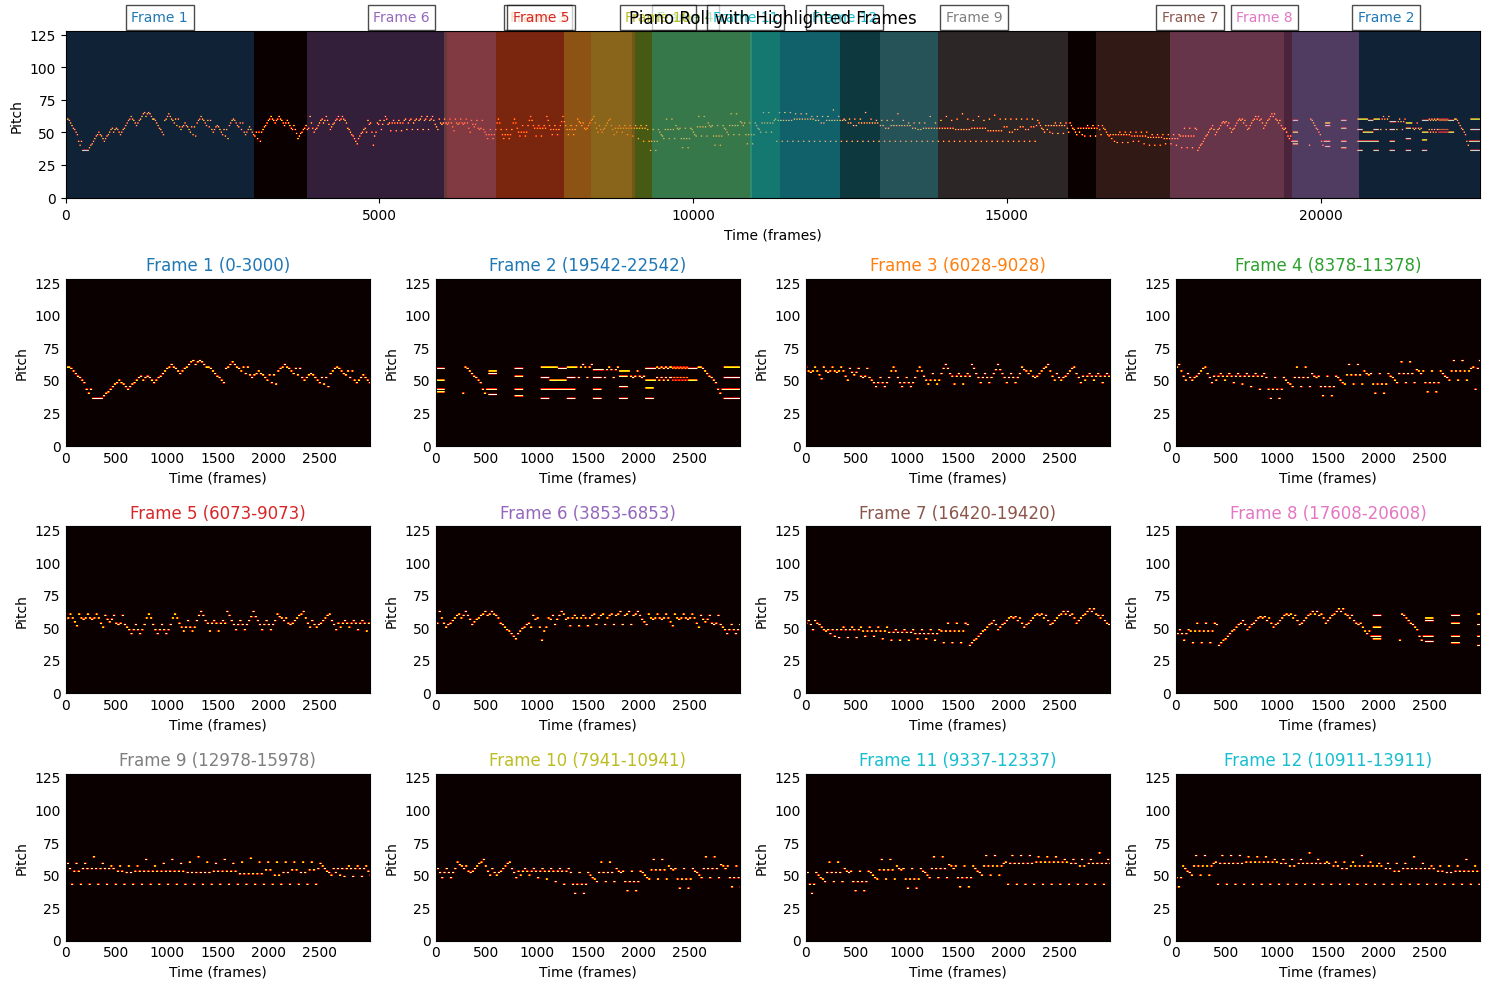

In [4]:
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

#lets load 1 example back in to view it
def load_frame(frame_id):
    return np.load(f"{DATA_DIR}/frames/{frame_id}.npy")

# Function to generate piano roll
def generate_piano_roll(file_path, fs=100):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    piano_roll = midi_data.get_piano_roll(fs=fs)
    return piano_roll



def plot_quality_check(piano_roll, extracted_frames, frame_indices, fs=100):
    """
    Plots the entire piano roll with shaded regions for frames and a 3x3 grid of extracted frames.

    Args:
        piano_roll: 2D NumPy array representing the piano roll.
        extracted_frames: List of 2D NumPy arrays for the extracted frames.
        frame_indices: List of tuples (start_index, end_index) for each frame.
        fs: Frames per second for the piano roll.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot the full piano roll at the top
    ax_main = plt.subplot2grid((4, 4), (0, 0), colspan=4)
    ax_main.imshow(piano_roll, aspect='auto', origin='lower', cmap='hot')
    ax_main.set_title('Piano Roll with Highlighted Frames')
    ax_main.set_ylabel('Pitch')
    ax_main.set_xlabel('Time (frames)')

    # Add shaded areas and labels for each frame
    colors = plt.cm.tab10(np.linspace(0, 1, len(frame_indices)))  # Generate unique colors
    for idx, (start, end) in enumerate(frame_indices):
        # Add a shaded rectangle
        ax_main.add_patch(patches.Rectangle(
            (start, 0),  # Bottom-left corner
            end - start,  # Width
            piano_roll.shape[0],  # Height
            linewidth=0,
            edgecolor=None,
            facecolor=colors[idx],
            alpha=0.3  # Semi-transparent shading
        ))

        # Add a label
        label_x = (start + end) / 2
        label_y = piano_roll.shape[0] + 5  # Slightly above the plot
        ax_main.text(label_x, label_y, f'Frame {idx+1}', color=colors[idx],
                     ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Plot extracted frames in a 3x3 grid
    for i, (frame, (start, end)) in enumerate(zip(extracted_frames, frame_indices)):
        ax = plt.subplot2grid((4, 4), (1 + i // 4, i % 4))
        ax.imshow(frame, aspect='auto', origin='lower', cmap='hot')
        ax.set_title(f'Frame {i+1} ({start}-{end})', color=colors[i])
        ax.set_ylabel('Pitch')
        ax.set_xlabel('Time (frames)')
        ax.tick_params(axis='both', which='both', length=0)  # Hide ticks

    # Adjust layout
    plt.tight_layout()
    plt.show()


example_file = dataset.iloc[0]
fs=100
frame_size=3000
piano_roll = generate_piano_roll(example_file["file_path"], fs=fs)
extracted_frames = [load_frame(x) for x in dataset[dataset['file_index'] == example_file.file_index]["frame_id"].tolist()]
frame_indices = [(start, start + frame_size) for start in dataset[dataset['file_index'] == example_file.file_index]["frame_start"]]
# Plot quality check
plot_quality_check(piano_roll, extracted_frames, frame_indices[:12], fs=100)

In [5]:
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

def build_cnn_model(input_shape):
    """
    Builds a simple CNN model for frame-based classification with regularization and F1 score tracking.

    Args:
        input_shape: Shape of the input frame (e.g., (128, 100, 1)).

    Returns:
        Compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(4, activation=None, name='logits'),  # Output logits
        layers.Activation('softmax', name='softmax_output')  # Softmax activation
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [6]:
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, validation_steps):
        super().__init__()
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps

    def on_epoch_end(self, epoch, logs=None):
        # Generate validation data
        y_true = []
        y_pred = []

        for _ in range(self.validation_steps):
            X_batch, y_batch = next(self.validation_generator)
            y_true.extend(np.argmax(y_batch, axis=1))
            y_pred.extend(np.argmax(self.model.predict(X_batch), axis=1))

        # Compute F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f" - val_f1: {f1:.4f}")
        logs['val_f1'] = f1  # Optionally store F1 in logs

In [7]:


def data_generator(df, frame_id_column, label_column, input_shape, batch_size):
    """
    Generator to load batches of data from disk for training.

    Args:
        df: DataFrame containing metadata and file paths.
        frame_id_column: Column with frame_id of the frame.
        label_column: Column containing the class labels.
        input_shape: Expected input shape for CNN (e.g., (128, 3000, 1)).
        batch_size: Number of samples per batch.

    Yields:
        A tuple (X_batch, y_batch) for training.
    """
    num_samples = len(df)
    labels = df[label_column].astype('category')
    label_map = {category: idx for idx, category in enumerate(labels.cat.categories)}
    
    while True:  # Infinite loop for generator
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_df = df.iloc[start_idx:end_idx]

            # Load frames and labels for the batch
            X_batch = []
            y_batch = []
            for _, row in batch_df.iterrows():
                frame = load_frame(row[frame_id_column])
                frame = frame.reshape(*input_shape)  # Reshape to match input_shape
                X_batch.append(frame)
                y_batch.append(label_map[row[label_column]])
            
            X_batch = np.array(X_batch)
            y_batch = to_categorical(y_batch, num_classes=len(label_map))

            yield X_batch, y_batch

def balanced_data_generator(df, frame_id_column, label_column, input_shape, batch_size):
    """
    Custom data generator for CNN training.

    Args:
        df: DataFrame containing dataset metadata.
        frame_id_column: Column in df containing frame paths or IDs.
        label_column: Column in df containing labels (e.g., composers).
        input_shape: Shape of the input for the CNN.
        batch_size: Number of samples per batch.

    Yields:
        X: Batch of input data.
        y: Batch of one-hot encoded labels.
    """
    # Create a mapping from composer names to numeric indices
    label_mapping = {label: idx for idx, label in enumerate(df[label_column].unique())}
    df['label_index'] = df[label_column].map(label_mapping)  # Add numeric labels to the DataFrame

    indices = np.arange(len(df))  # Create an index array
    while True:  # Infinite loop for generator
        np.random.shuffle(indices)  # Shuffle indices
        for start_idx in range(0, len(df), batch_size):
            end_idx = min(start_idx + batch_size, len(df))
            batch_indices = indices[start_idx:end_idx]
            batch_df = df.iloc[batch_indices]

            # Load frames and labels
            X = np.array([load_frame(row[frame_id_column]) for _, row in batch_df.iterrows()])
            y = to_categorical(batch_df['label_index'].values, num_classes=len(label_mapping))

            yield X, y

In [8]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Example usage
input_shape = (128, 3000, 1)  # Example frame shape (pitches, time steps, channels)
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()

/root/.local/share/hatch/env/virtual/classical-composer/ZrSL52l9/jupyter/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738115983.328396    7966 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 2998, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 1499, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 1499, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 1497, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 748, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 748, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1436160)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    91,914,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Activation)     │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,933,380 (350.70 MB)

 Trainable params: 91,933,380 (350.70 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Generator parameters
input_shape = (128, 3000, 1)
batch_size = 8

# Training and validation generators
train_gen = balanced_data_generator(train_df, 'frame_id', 'composer', input_shape, batch_size)
val_gen = data_generator(validation_df, 'frame_id', 'composer', input_shape, batch_size)

# Calculate the steps per epoch
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
f1_callback = F1ScoreCallback(validation_generator=val_gen, validation_steps=validation_steps)

# Train the model
cnn_model = build_cnn_model(input_shape=(128, 3000, 1))
history = cnn_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/50


I0000 00:00:1738115987.745587    8170 service.cc:148] XLA service 0x7faae8004f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738115987.745897    8170 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-01-29 01:59:47.802785: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738115987.991696    8170 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/426 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.2188 - loss: 276.0650 - precision: 0.2188 - recall: 0.2188 

I0000 00:00:1738115995.470036    8170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


426/426 ━━━━━━━━━━━━━━━━━━━━ 119s 258ms/step - accuracy: 0.5827 - loss: 63.5646 - precision: 0.6421 - recall: 0.3972 - val_accuracy: 0.6939 - val_loss: 6.5264 - val_precision: 0.7778 - val_recall: 0.0572 - learning_rate: 0.0010
Epoch 2/50


2025-01-29 02:01:46.883485: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1628', 4 bytes spill stores, 4 bytes spill loads



426/426 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - accuracy: 0.7012 - loss: 5.7586 - precision: 0.7684 - recall: 0.5415 - val_accuracy: 0.6928 - val_loss: 4.8329 - val_precision: 0.7645 - val_recall: 0.3224 - learning_rate: 0.0010
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 114s 268ms/step - accuracy: 0.7392 - loss: 4.2795 - precision: 0.8215 - recall: 0.6608 - val_accuracy: 0.6822 - val_loss: 4.4231 - val_precision: 0.7763 - val_recall: 0.4054 - learning_rate: 0.0010
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 120s 282ms/step - accuracy: 0.7614 - loss: 3.7753 - precision: 0.8404 - recall: 0.6959 - val_accuracy: 0.6976 - val_loss: 4.0495 - val_precision: 0.7368 - val_recall: 0.6094 - learning_rate: 0.0010
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 99s 233ms/step - accuracy: 0.7659 - loss: 3.6445 - precision: 0.8450 - recall: 0.7019 - val_accuracy: 0.6939 - val_loss: 4.7704 - val_precision: 0.7235 - val_recall: 0.6449 - learning_rate: 0.0010
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 98s 229ms/step - acc

In [11]:
cnn_model.save(f"{DATA_DIR}/cnn_model.keras")
with open(f"{DATA_DIR}/training_history.json", "w") as f:
    json.dump(history.history, f)
with open(f"{DATA_DIR}/training_history.json", "r") as f:
    loaded_history = json.load(f)

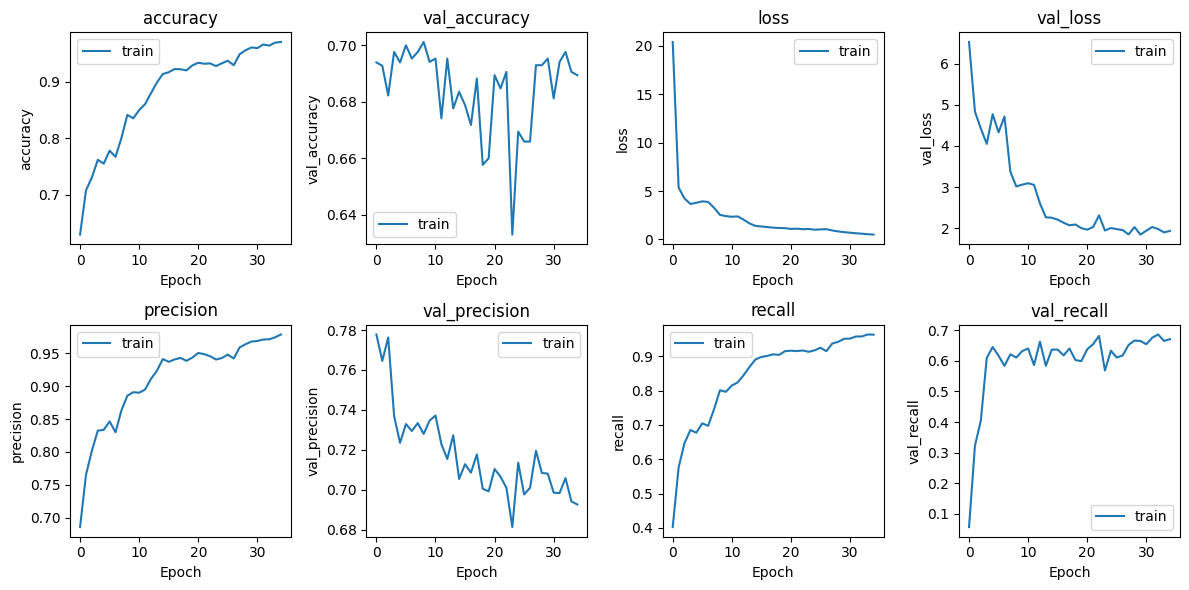

In [12]:
def plot_training_history(history):
    """
    Plot accuracy, loss, precision, and recall from training history.

    Args:
        history: Training history object from TensorFlow or loaded history JSON.
    """
    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'precision', 'val_precision', 'recall', 'val_recall']
    plt.figure(figsize=(12, 6))

    for i, metric in enumerate(metrics, 1):
        if metric in history:
            plt.subplot(2, 4, i)
            plt.plot(history[metric])
            plt.title(metric)
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.legend(['train', 'val'])

    plt.tight_layout()
    plt.show()

# Plot history
plot_training_history(loaded_history)

['Bach', 'Beethoven', 'Brahms', 'Schubert']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━

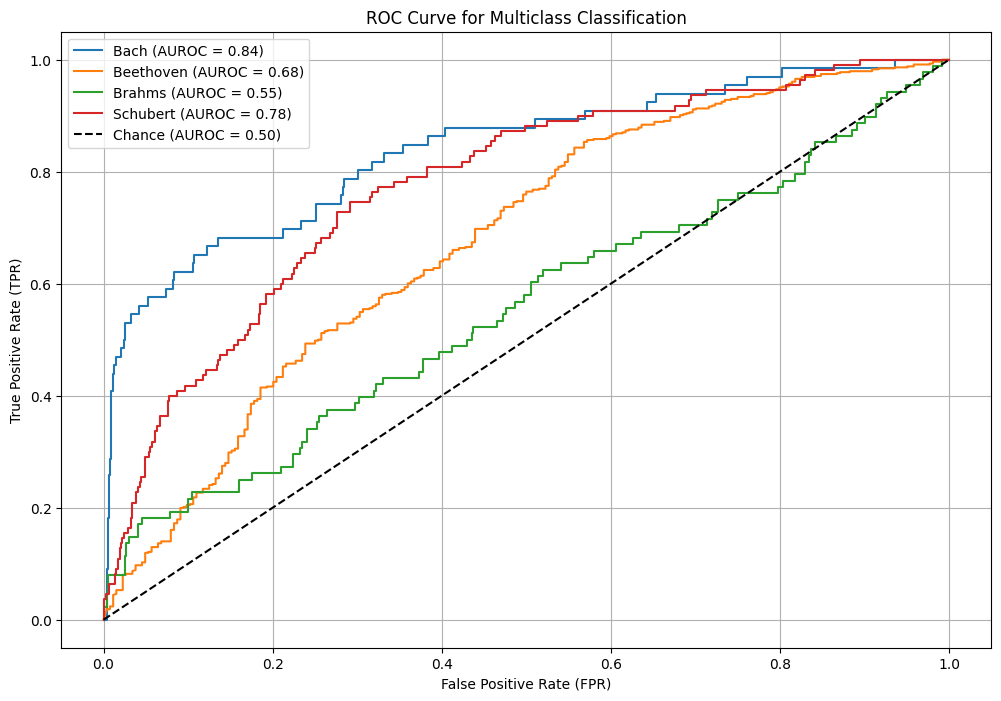

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc_auc(model, validation_gen, validation_steps, composer_labels):
    """
    Plot ROC curves and calculate AUROC for multiclass classification with composer labels.

    Args:
        model: Trained TensorFlow model.
        validation_gen: Validation data generator.
        validation_steps: Number of steps in the validation generator.
        composer_labels: List of composer names corresponding to class indices.
    """
    num_classes = len(composer_labels)
    y_true = []
    y_scores = []

    # Collect true labels and predicted probabilities
    for _ in range(validation_steps):
        X_batch, y_batch = next(validation_gen)
        y_true.extend(np.argmax(y_batch, axis=1))  # True class indices
        y_scores.extend(model.predict(X_batch))  # Predicted probabilities

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize the true labels for one-vs-rest strategy
    y_true_binary = label_binarize(y_true, classes=np.arange(num_classes))

    plt.figure(figsize=(12, 8))
    for class_idx, composer_name in enumerate(composer_labels):
        fpr, tpr, _ = roc_curve(y_true_binary[:, class_idx], y_scores[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{composer_name} (AUROC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUROC = 0.50)")
    plt.title("ROC Curve for Multiclass Classification")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.grid()
    plt.show()

    
composer_labels = train_df['composer'].astype('category').cat.categories.tolist()
print(composer_labels)
plot_multiclass_roc_auc(cnn_model, val_gen, validation_steps, composer_labels)



In [14]:
#TODO: Use the CNN as feature extractor, train Kmeans for cluster assignment and continue with pipeline

# Create the logits model
logits_model = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer('logits').output
)

# Generate logits using the logits model
logits = logits_model.predict(test_inputs)

# Apply sigmoid activation
sigmoid_outputs = tf.nn.sigmoid(logits).numpy()

AttributeError: The layer sequential_1 has never been called and thus has no defined input.